<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/Desafio6_San_Bartolom%C3%A9_Carlos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 6 - Ejemplo con Tarea

<img src='https://escuela.pucp.edu.pe/gobierno/wp-content/uploads/2015/04/logo-pucp-full-color-300x88.png' width=200px>


Dr. Edwin Villanueva, Ing. Daniel Saromo

<font color='orange'>Entorno de MDP con definición de recompensa $R(s)$ en función del estado $s$. Tarea: Resolver 2 entornos del carro acelerando (CS188).</font>



Códigos adaptados del repositorio [aima-python](https://github.com/aimacode/aima-python).

El presente notebook aborda la implementación genérica de un proceso de decisiones de markov (MDP, por sus siglas en inglés). Luego, se lo aplica al problema del **carro acelerando**. 

## MDP: Definition

In [21]:
class MDP:

    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [page 646]"""

    def __init__(self, init, actlist, terminals, transitions = {}, reward = None, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            ## collect states from transitions table
            self.states = self.get_states_from_transitions(transitions)
            
        
        self.init = init
        
        if isinstance(actlist, list):
            ## if actlist is a list, all states have the same actions
            self.actlist = actlist
        elif isinstance(actlist, dict):
            ## if actlist is a dict, different actions for each state
            self.actlist = actlist
        
        self.terminals = terminals
        self.transitions = transitions
        if self.transitions == {}:
            print("Warning: Transition table is empty.")
        self.gamma = gamma
        if reward:
            self.reward = reward
        else:
            self.reward = {s : 0 for s in self.states}
        #self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set([tr[1] for actions in transitions.values() 
                              for effects in actions.values() for tr in effects])
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):
        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)
        # check that init is a valid state
        assert self.init in self.states
        # check reward for each state
        #assert set(self.reward.keys()) == set(self.states)
        assert set(self.reward.keys()) == set(self.states)
        # check that all terminals are valid states
        assert all([t in self.states for t in self.terminals])
        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

El método **_ _init_ _** recibe los siguientes parámetros:

- `init`: el estado inicial.
- `actlist`: lista de acciones posibles para cada estado.
- `terminals`: lista de estados terminales donde la única acción posible es salir
- `gamma`: Factor de descuento. Permite asegurar que las recompensas más antiguas tengan menor valor que las inmediatas.

El método **R** retorna la recompensa de cada state usando el diccionario `self.reward`.

El método **T** no está implementado en la clase genérica `MDP`, sino que se debe implementar en el entorno específico en el que aplicaremos el MDP. Con este método (**T**), retornamos tuplas `(probability, s')` pairs, donde `s'` es una lista de posibles estados resultantes a partir de realizar la acción `a` en el estado `s`.

El método **actions** retorna una lista de acciones posibles a partir de cada estado. Por defecto, retorna todas las acciones para los estados no terminales.

## MDP: Example

In [22]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma) 
    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return self.transitions[state][action]
           

Ahora vamos a implementar el MDP mostrado en la imagen a continuación. Los estados A y B tienen acciones X, Y disponibles. Sus probabilidades se muestran sobre las flechas. Utilizaremos la clase `MDP` como base para nuestra clase hija `CustomMDP`, adaptando el código a nuestro caso. Haremos uso de una matriz de transición, ya que nuestras transiciones entre estados no son muy simples.


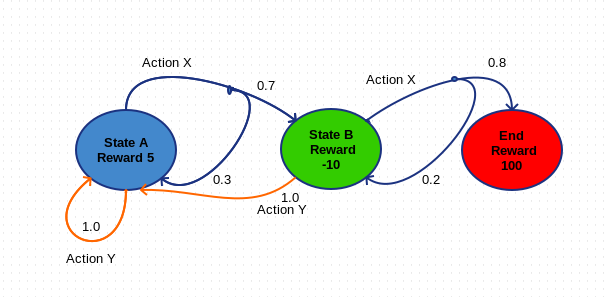

In [23]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

Instanciamos la clase `CustomMDP` con los parámetros definidos arriba, de acuerdo a la figura mostrada.

In [24]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=0.99)

De esta manera, hemos realizado una implementación que representa nuestro MDP. Ahora veremos como resolver este MDP.

## MDP: Solving

In [25]:
argmax=max
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration. [Figure 17.4]"""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
      U = U1.copy()
      delta = 0
      
      for s in mdp.states:
        #para cada acción, obtener el máximo valor de sumar 
        #el producto del modelo de transacción (P(s1|s,a)) por la utilidad del nuevo estado (U[s1])
        U1[s] = R(s) + gamma*max(sum(p* U[s1] for (p, s1) in mdp.T(s,a)) for a in mdp.actions(s))
        delta = max(delta, abs(U1[s]-U[s]))
      if delta < (epsilon * (1 - gamma) / gamma): 
        return U

def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. (Equation 17.4)"""

    pi = {}
    for s in mdp.states:
        pi[s] = argmax(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi


def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))

In [26]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [27]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=0.9)

In [28]:
uuu = value_iteration(our_mdp)
#uuu = value_iteration(our_mdp,iterations=20)
print(uuu)

{'End': 100.0, 'B': 75.60975599852492, 'A': 72.10147625879485}


In [29]:
pi = best_policy(our_mdp, uuu)

In [30]:
pi

{'A': 'X', 'B': 'X', 'End': None}

Realicemos una verificación intuitiva de los resultados obtenidos por el agente luego de resolver el mapa asociado al Proceso de Decisión Markoviano (PDM) presentado

## Desafío de la Semana: Entorno del carro acelerando (2 puntos)

Se plantea el problema en el que se tiene un carro en una carrera, el cual puede aumentar su velocidad (acción *Fast*) o ir más lento (acción *Slow*). Sin embargo, este vehículo puede llegar a aumentar demasiado su temperatura hasta sobrecalentarse y dejar de funcionar.

Considerando el mapa de transición con las probabilidades mostradas en los gráficos; para cada estado, ¿cuál sería la acción que debería realizar un agente que controle el carro?

Utilizando únicamente códigos proporcionados en este notebook, implementar los siguientes 2 entornos (adaptados del curso [CS188](https://inst.eecs.berkeley.edu/~cs188/fa19/)) y hallar la política adecuada usando el método de iteración de valor (ya implementada por la función `value_iteration`).


### Entorno 1 (1 punto)

Recompensa asociada al estado.

Usar `gamma=0.9` en el MDP.

![ejemplo1](https://i.ibb.co/xLtYQrt/example-car-simple-XD.png) 

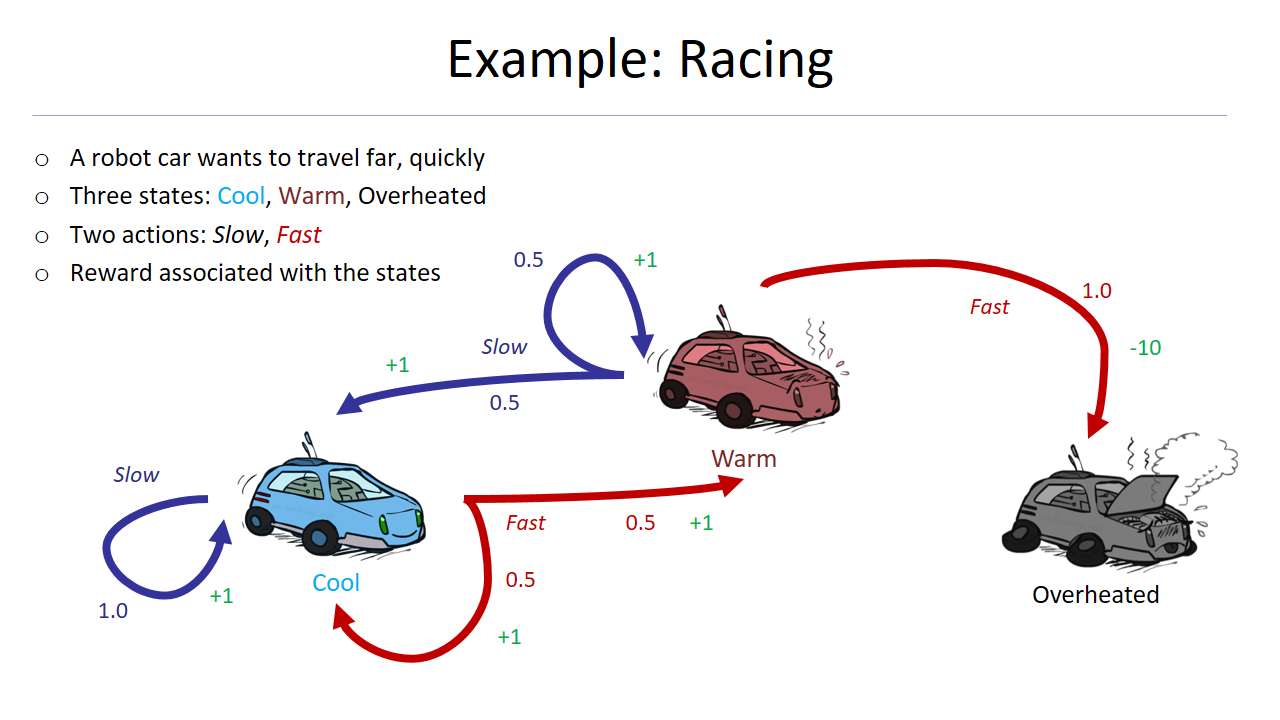

In [31]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
#****************************************************************
t = {
    "cool": {
            "fast": [(0.5, "warm"), (0.5, "cool")],
            "slow": [(1.0, "cool")]
         },
    "warm": {
            "fast": [(1.0, "overheated")],
            "slow": [(0.5, "warm"), (0.5, "cool")]
         },
    "overheated": {}
}

init = "cool"

terminals = ["overheated"]

rewards = {
    "cool": 1,
    "warm": 1,
    "overheated": -10
}

In [32]:
tarea_mdp_1 = CustomMDP(init, terminals, t, rewards, gamma=0.9)

In [33]:
uuuu_1 = value_iteration(tarea_mdp_1)
#uuuu_1 = value_iteration(tarea_mdp_1,iterations=20)
print(uuuu_1)

{'warm': 9.998955043236684, 'overheated': -10.0, 'cool': 9.998955043236684}


In [34]:
tarea_pi_1 = best_policy(tarea_mdp_1, uuuu_1)

In [35]:
tarea_pi_1

{'cool': 'fast', 'overheated': None, 'warm': 'slow'}

 ### Entorno 2: Doble recompensa si se aumenta la velocidad (1 punto)

Ahora, un mismo estado físico se vincula a dos valores diferentes de recompensa.

Usar `gamma=0.9` en el MDP.

![ejemplo2](https://i.stack.imgur.com/QNV7Z.jpg) 

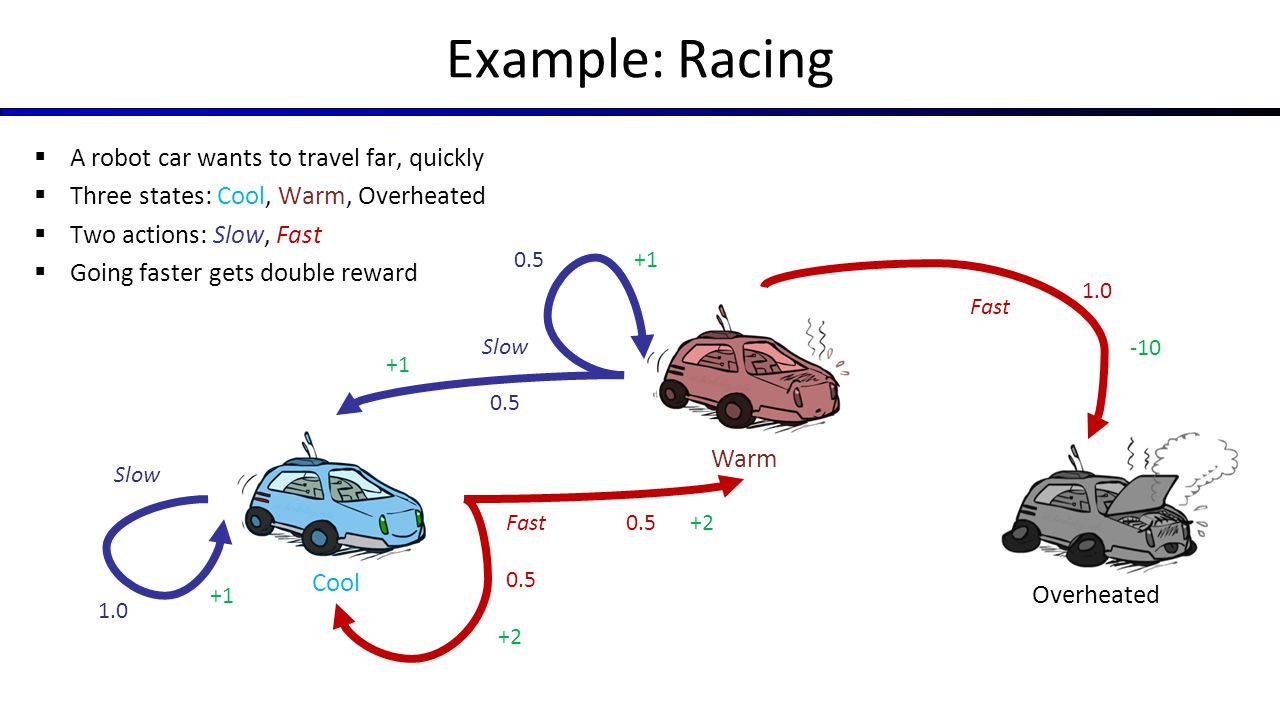

In [36]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
#****************************************************************
t = {
    "coolA": {
            "fast": [(0.5, "warmB"), (0.5, "coolB")],
            "slow": [(1.0, "coolA")]
         },
    "coolB": {
            "fast": [(0.5, "warmB"), (0.5, "coolB")],
            "slow": [(1.0, "coolA")]
         },
    "warmA": {
            "fast": [(1.0, "overheated")],
            "slow": [(0.5, "warmA"), (0.5, "coolA")]
         },
    "warmB": {
            "fast": [(1.0, "overheated")],
            "slow": [(0.5, "warmA"), (0.5, "coolA")]
         },
    "overheated": {}
}

init = "coolA"

terminals = ["overheated"]

rewards = {
    "coolA": 1,
    "coolB": 2,
    "warmA": 1,
    "warmB": 2,
    "overheated": -10
}

In [37]:
tarea_mdp_2 = CustomMDP(init, terminals, t, rewards, gamma=0.9)

In [38]:
uuuu_2 = value_iteration(tarea_mdp_2)
#uuuu_2 = value_iteration(tarea_mdp_2,iterations=20)
print(uuuu_2)

{'overheated': -10.0, 'warmB': 15.048971605801386, 'warmA': 14.048971605801386, 'coolA': 14.948971605801386, 'coolB': 15.948971605801386}


In [39]:
tarea_pi_2 = best_policy(tarea_mdp_2, uuuu_2)

In [40]:
tarea_pi_2

{'coolA': 'fast',
 'coolB': 'fast',
 'overheated': None,
 'warmA': 'slow',
 'warmB': 'slow'}